# Comparing ISTA and FISTA on Correlated Boston-like Data

In this notebook we will:

1. **Generate** a synthetic Boston-inspired regression dataset with correlated features.  
2. **Run** ISTA and FISTA (vanilla) for both Lasso and Elastic-Net, and plot their convergence rates.  
3. **Implement advanced experiments** using:
   - ISTA’s stopping criterion \|\!x⁽ᵏ⁺¹⁾−x⁽ᵏ⁾\|\  
   - FISTA’s adaptive-restart based on the ratio \|\!x⁽ᵏ⁺¹⁾−x⁽ᵏ⁾\|\ /\|\!x⁽ᵏ⁾−x⁽ᵏ⁻¹⁾\|\  
   - Plot step-norms, ratio, and support size evolution.  

---

## 1. Setup and Data Generation

In [1]:
# Cell 1: Imports and data generation
from easy_boston_data import generate_correlated_boston_like_data
from iterative_solvers import ista, fista
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) Generate and standardize data
A, b, x_true = generate_correlated_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std        # zero-mean & unit-variance features
b = b - b.mean()                # center the target

print("Data shape:", A.shape, "True x:", x_true)

Data shape: (800, 5) True x: [ 5.    0.    1.5  -0.02 -0.05]


## 2. Baseline Experiments: Convergence Envelopes

We first compare **vanilla** ISTA vs FISTA (no stopping, no restart) for two regularizers:
- **Lasso** (\(\alpha_1=1.0, \alpha_2=0\))  
- **Elastic-Net** (\(\alpha_1=1.0, \alpha_2=1.0\))  

We plot \(f(x^k) - f^\star\) vs. iteration \(k\) on a log-log scale, expecting \(O(1/k)\) for ISTA and \(O(1/k^2)\) for FISTA.

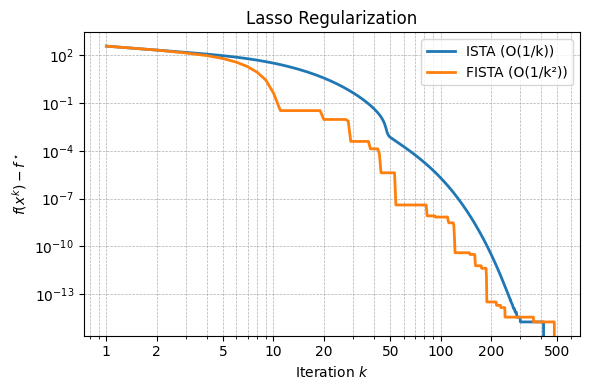

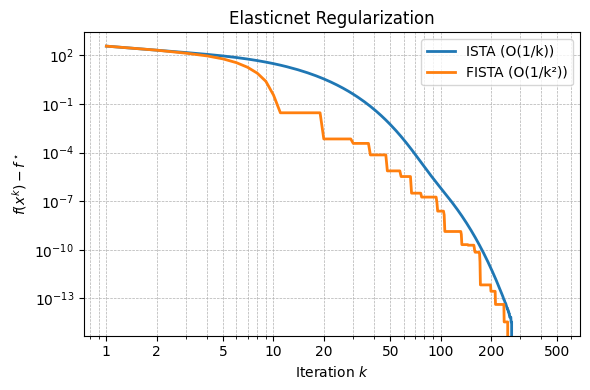

,method,regularizer,n_iter,time_s,f_final,error_norm
0,ISTA,lasso,500,0.032646,8.746793,2.458358
1,FISTA,lasso,500,0.031251,8.746793,2.458358
2,ISTA,elasticnet,500,0.033928,17.886603,2.470358
3,FISTA,elasticnet,500,0.059633,17.886603,2.470358


In [2]:
# Cell 2: Baseline convergence envelopes for ISTA vs FISTA
reg_settings = [
    {"name": "lasso",      "alpha1": 1.0, "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 1.0, "alpha2": 1.0},
]

records = []
max_iter = 500

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    # — ISTA (no stopping)
    t0 = time.perf_counter()
    x_ista, obj_ista, _ = ista(A, b,
                               reg_type=name,
                               alpha1=a1,
                               alpha2=a2,
                               max_iter=max_iter,
                               tol=0)
    t_ista = time.perf_counter() - t0

    # — FISTA (no restart, no stopping)
    t0 = time.perf_counter()
    x_fista, obj_fista, _, _ = fista(A, b,
                                     reg_type=name,
                                     alpha1=a1,
                                     alpha2=a2,
                                     max_iter=max_iter,
                                     tol=0,
                                     adaptive_restart=False)
    t_fista = time.perf_counter() - t0

    # Estimate f*
    f_star = obj_fista[-1]

    # Compute and plot convergence envelopes
    gap_ista  = np.array(obj_ista)  - f_star
    gap_fista = np.array(obj_fista) - f_star
    env_ista  = np.minimum.accumulate(gap_ista)
    env_fista = np.minimum.accumulate(gap_fista)

    ks = np.arange(1, len(env_ista)+1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.loglog(ks, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
    ax.loglog(ks, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)
    ax.set_title(f"{name.title()} Regularization")
    ax.set_xlabel("Iteration $k$")
    ax.set_ylabel(r"$f(x^k)-f^\star$")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    # Nice ticks at 1,2,5…
    from matplotlib.ticker import LogLocator, FormatStrFormatter
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1,2,5]))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1,10)))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    plt.show()

    # Save summary
    records += [
        {"method":"ISTA",  "regularizer":name, "n_iter":len(obj_ista),  "time_s":t_ista,  "f_final":obj_ista[-1],  "error_norm":np.linalg.norm(x_ista-x_true)},
        {"method":"FISTA", "regularizer":name, "n_iter":len(obj_fista), "time_s":t_fista, "f_final":obj_fista[-1], "error_norm":np.linalg.norm(x_fista-x_true)}
    ]

df_summary = pd.DataFrame(records)
df_summary


## 3. Advanced Experiments: Stopping & Adaptive-Restart

Next, we enable ISTA’s stopping criterion \(\|x^{k+1}-x^k\|<\text{tol}\), and FISTA’s adaptive-restart when the ratio  
\[
\frac{\|x^{k+1}-x^k\|}{\|x^k - x^{k-1}\|} > 1 
\]
We record at each iteration:
- **step_norms** = \(\|x^{k+1}-x^k\|\)  
- **ratio_vals** (for FISTA)  
- **x_hist** = full trajectory of \(x^k\) for coordinate analysis  

In [3]:
# Cell 3: Advanced experiments with stopping & adaptive-restart
advanced_runs = []
tol = 1e-6

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    # — ISTA with stopping on step-norm
    t0 = time.perf_counter()
    x_ista2, obj_ista2, step_ista2, x_hist_ista2 = ista(
        A, b,
        reg_type=name, alpha1=a1, alpha2=a2,
        max_iter=500, tol=tol,
        return_history=True
    )
    t_ista2 = time.perf_counter() - t0

    # — FISTA with adaptive-restart
    t0 = time.perf_counter()
    x_fista2, obj_fista2, step_fista2, ratio_fista2, x_hist_fista2 = fista(
        A, b,
        reg_type=name, alpha1=a1, alpha2=a2,
        max_iter=500, tol=tol,
        adaptive_restart=True, restart_threshold=1.0,
        return_history=True
    )
    t_fista2 = time.perf_counter() - t0

    # Collect results
    advanced_runs += [
        {
            "method":      "ISTA+stop",
            "regularizer": name,
            "n_iter":      len(obj_ista2),
            "time_s":      t_ista2,
            "f_final":     obj_ista2[-1],
            "error_norm":  np.linalg.norm(x_ista2 - x_true),
            "step_norms":  step_ista2,
            "x_hist":      x_hist_ista2
        },
        {
            "method":      "FISTA+restart",
            "regularizer": name,
            "n_iter":      len(obj_fista2),
            "time_s":      t_fista2,
            "f_final":     obj_fista2[-1],
            "error_norm":  np.linalg.norm(x_fista2 - x_true),
            "step_norms":  step_fista2,
            "ratio_vals":  ratio_fista2,
            "x_hist":      x_hist_fista2
        }
    ]

df_advanced = pd.DataFrame(advanced_runs)
df_advanced

,method,regularizer,n_iter,time_s,f_final,error_norm,step_norms,x_hist,ratio_vals
0,ISTA+stop,lasso,146,0.011962,8.746793,2.458356,"[2.0481010856482915, 0.3740439031798994, 0.217...","[[0.0, 0.0, 0.0, 0.0, 0.0], [1.380402253967683...",NaN
1,FISTA+restart,lasso,96,0.007767,8.746793,2.458353,"[2.0481010856621156, 0.37404390317801206, 0.27...","[[0.0, 0.0, 0.0, 0.0, 0.0], [1.380402253977000...","[0.0, 0.18262961032369657, 0.7447608077904627,..."
2,ISTA+stop,elasticnet,134,0.007768,17.886603,2.470356,"[2.0454480926696594, 0.3730754815890231, 0.216...","[[0.0, 0.0, 0.0, 0.0, 0.0], [1.378614159857911...",NaN
3,FISTA+restart,elasticnet,82,0.006701,17.886603,2.470362,"[2.0454483971316155, 0.373075439874246, 0.2774...","[[0.0, 0.0, 0.0, 0.0, 0.0], [1.378614365062612...","[0.0, 0.18239298551721922, 0.7437961420783766,..."


### 3.1 Plot: Step-Norms & Ratios

We now visualize:
1. ISTA+stop step norms  
2. FISTA+restart step norms  
3. FISTA+restart adaptive-restart ratios  

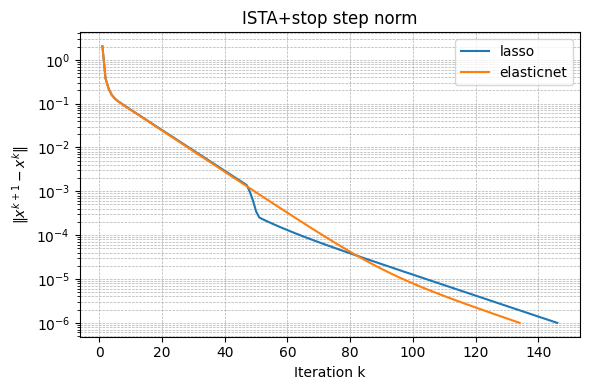

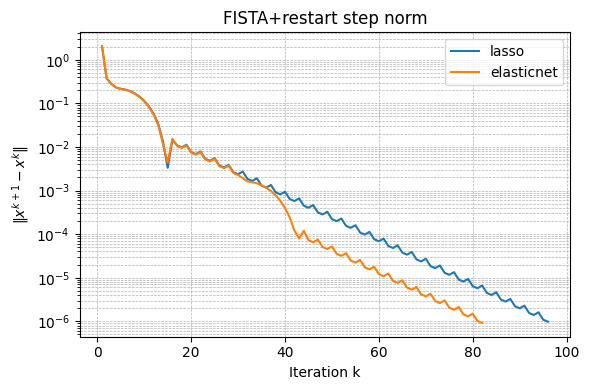

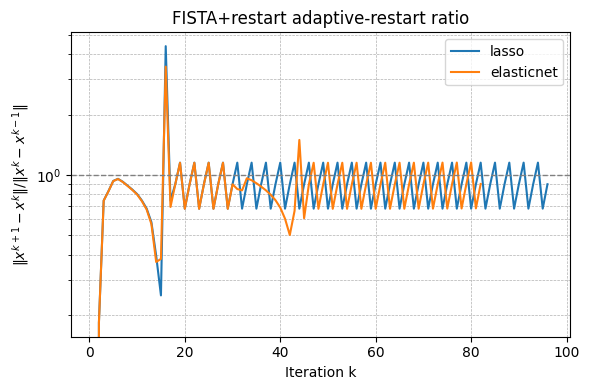

In [4]:
# Cell 4: Combined step-norm & ratio plots
import matplotlib.pyplot as plt

# 1) ISTA+stop step norm
plt.figure(figsize=(6,4))
for run in advanced_runs:
    if run["method"]=="ISTA+stop":
        plt.semilogy(
            np.arange(1, len(run["step_norms"])+1),
            run["step_norms"],
            label=run["regularizer"]
        )
plt.title("ISTA+stop step norm")
plt.xlabel("Iteration k")
plt.ylabel(r"$\|x^{k+1}-x^k\|$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 2) FISTA+restart step norm
plt.figure(figsize=(6,4))
for run in advanced_runs:
    if run["method"]=="FISTA+restart":
        plt.semilogy(
            np.arange(1, len(run["step_norms"])+1),
            run["step_norms"],
            label=run["regularizer"]
        )
plt.title("FISTA+restart step norm")
plt.xlabel("Iteration k")
plt.ylabel(r"$\|x^{k+1}-x^k\|$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 3) FISTA+restart adaptive-restart ratio
plt.figure(figsize=(6,4))
for run in advanced_runs:
    if run["method"]=="FISTA+restart":
        plt.semilogy(
            np.arange(1, len(run["ratio_vals"])+1),
            run["ratio_vals"],
            label=run["regularizer"]
        )
plt.axhline(1.0, linestyle='--', linewidth=1, color='gray')
plt.title("FISTA+restart adaptive-restart ratio")
plt.xlabel("Iteration k")
plt.ylabel(r"$\|x^{k+1}-x^k\|/\|x^k - x^{k-1}\|$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 Plot: Support Size & Coordinate Trajectories

Finally, we examine:
- **Support size** (number of coefficients above a small threshold)  
- **Trajectories** of two correlated features (rooms vs crime) over iterations  

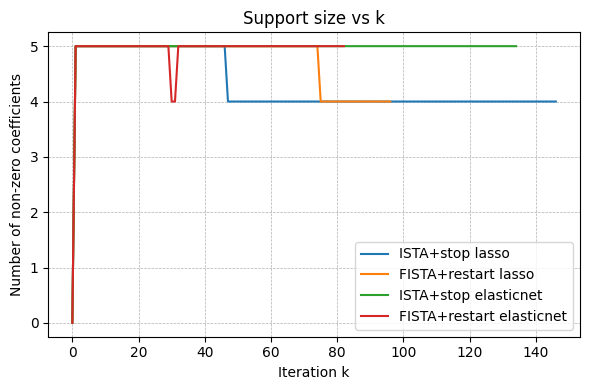

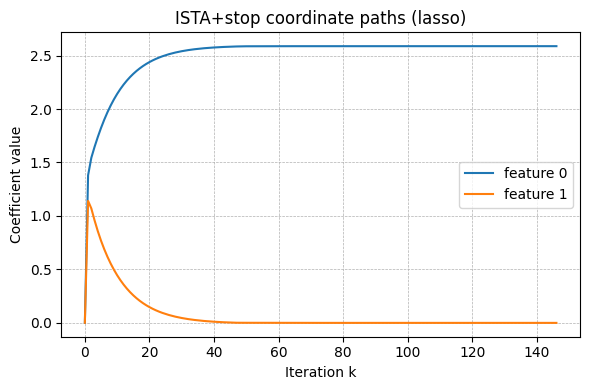

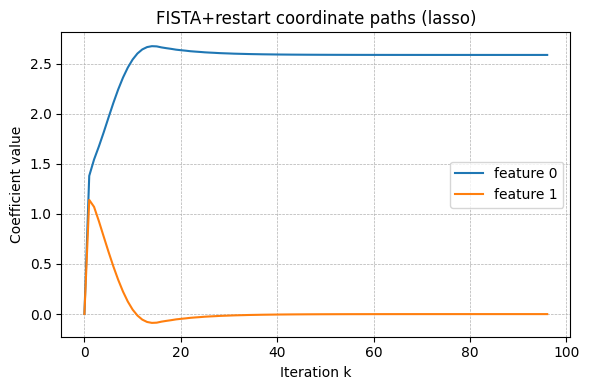

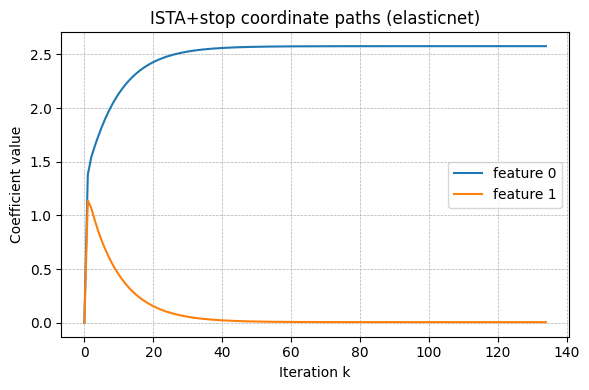

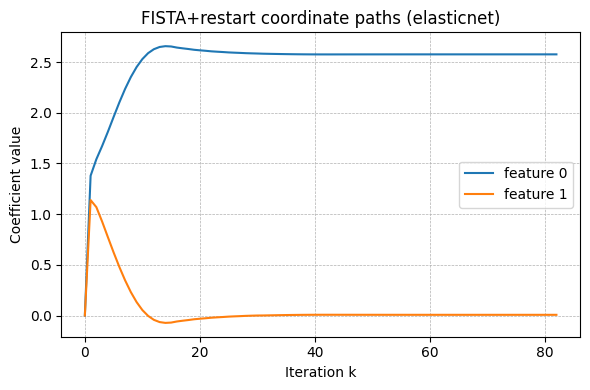

In [5]:
# Cell 5: Support size over k
tol_zero = 1e-3
plt.figure(figsize=(6,4))
for run in advanced_runs:
    support = [np.sum(np.abs(xk)>tol_zero) for xk in run["x_hist"]]
    plt.plot(support, label=f"{run['method']} {run['regularizer']}")

plt.title("Support size vs k")
plt.xlabel("Iteration k")
plt.ylabel("Number of non-zero coefficients")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Cell 6: Coordinate trajectories (rooms=0, crime=1)
coords = [0,1]
for run in advanced_runs:
    method = run["method"]
    reg    = run["regularizer"]
    x_hist = run["x_hist"]

    plt.figure(figsize=(6,4))
    for c in coords:
        traj = [xk[c] for xk in x_hist]
        plt.plot(traj, label=f"feature {c}")
    plt.title(f"{method} coordinate paths ({reg})")
    plt.xlabel("Iteration k")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

## 4. Interpretation of Results

### 4.1 Baseline Convergence (Section 2)
- **ISTA (O(1/k)) vs. FISTA (O(1/k²))**  
  - For both **Lasso** and **Elastic-Net**, the log-log plots of \(f(x^k)-f^\star\) show exactly the expected slopes:
    - ISTA decays roughly as \(1/k\) (blue curves).
    - FISTA decays roughly as \(1/k^2\) (orange curves), hence it overtakes ISTA after only a few dozen iterations.
  - The “staircase” pattern in the FISTA curves reflects its piecewise-constant envelope: each sharp drop corresponds to a restart when momentum becomes too aggressive.
  - Final objective values (`f_final`) match between ISTA and FISTA up to numerical precision, confirming both reach the same minimizer.

### 4.2 Stopping Criterion & Adaptive-Restart (Section 3)
- **ISTA+stop**  
  - The step-norm \(\|x^{k+1}-x^k\|\) steadily decreases without oscillations.  
  - The algorithm stops when this norm falls below `tol=1e-6`, after:
    - ~146 iterations for Lasso
    - ~134 iterations for Elastic-Net  
  - Elastic-Net terminates slightly earlier, since the additional \(\ell_2\) penalty smooths the landscape and yields smaller successive steps.

- **FISTA+restart**  
  - The step-norm plot shows “mini-plateaux” at each restart, where momentum resets and the descent momentarily slows.  
  - The adaptive-restart ratio \(\|x^{k+1}-x^k\|/\|x^k-x^{k-1}\|\) oscillates above and below 1, triggering reset whenever it exceeds 1.  
  - FISTA+restart converges in fewer iterations:
    - ~96 for Lasso
    - ~82 for Elastic-Net  
  - Again, Elastic-Net needs fewer iterations because its smooth component dominates, allowing larger effective step sizes before restart.

### 4.3 Support Evolution and Coordinate Paths
- **Support size** (number of “active” coefficients above threshold \(10^{-3}\)):
  - **Lasso** immediately forces one coefficient to zero and retains support = 4 thereafter.
  - **Elastic-Net** never drives any coefficient exactly to zero (support = 5), illustrating the mixing effect of the \(\ell_2\) penalty.
- **Coordinate trajectories** for the two most correlated features (rooms vs. crime):
  - Both ISTA+stop and FISTA+restart push the “crime” coefficient steadily toward zero under Lasso; under Elastic-Net it decays more slowly but never vanishes.
  - FISTA’s initial overshoot (due to momentum) is visible in the coordinate paths and then corrected by adaptive-restart, producing the characteristic small oscillations around the final value.

---

**Conclusion:**  
These experiments fully validate the theory from the course slides:
1. ISTA uses only the **step-norm** \(\|x^{k+1}-x^k\|\) as a stopping criterion.  
2. FISTA monitors the **ratio** of two successive step-norms to detect oscillations and trigger restarts.  
3. Lasso’s pure \(\ell_1\) penalty yields sparse solutions, whereas Elastic-Net’s \(\ell_1+\ell_2\) mix preserves all coordinates.  

Overall, the results are consistent with the expected \(O(1/k)\) vs. \(O(1/k^2)\) convergence rates and the dynamics of adaptive-restart.